In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
import joblib

In [56]:
print("TensorFlow version:", tf.__version__)
print("TensorFlow built with CUDA:", tf.test.is_built_with_cuda())
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.10.0
TensorFlow built with CUDA: True
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [57]:
tf.random.set_seed(42)

## Preprocessing Data

In [58]:
data = pd.read_csv("../data/processed/weatherQN_2021_2025_processed.csv", parse_dates=["time"])
data.set_index("time", inplace=True)
data.drop(columns='coco', inplace=True)

data.head()

,temp,dwpt,rhum,prcp,wdir,wspd,pres
time,,,,,,,
2021-01-02 00:00:00,20.0,17.4,85.0,0.0,350.0,20.2,1017.9
2021-01-02 03:00:00,20.0,17.8,87.0,0.2,343.0,17.6,1016.1
2021-01-02 06:00:00,19.8,17.8,88.0,0.1,339.0,17.6,1016.7
2021-01-02 09:00:00,20.2,18.3,89.0,0.2,347.0,18.7,1018.4
2021-01-02 12:00:00,22.0,18.0,78.0,0.1,3.0,28.4,1016.4


In [59]:
data.head()

,temp,dwpt,rhum,prcp,wdir,wspd,pres
time,,,,,,,
2021-01-02 00:00:00,20.0,17.4,85.0,0.0,350.0,20.2,1017.9
2021-01-02 03:00:00,20.0,17.8,87.0,0.2,343.0,17.6,1016.1
2021-01-02 06:00:00,19.8,17.8,88.0,0.1,339.0,17.6,1016.7
2021-01-02 09:00:00,20.2,18.3,89.0,0.2,347.0,18.7,1018.4
2021-01-02 12:00:00,22.0,18.0,78.0,0.1,3.0,28.4,1016.4


### Scaling data

In [60]:
scaler = StandardScaler()
features = ['temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'wspd', 'pres']
data[features] = scaler.fit_transform(data[features])

In [61]:
data.head()

,temp,dwpt,rhum,prcp,wdir,wspd,pres
time,,,,,,,
2021-01-02 00:00:00,-1.773390,-2.171929,0.344100,-0.238101,1.356535,0.661832,1.704744
2021-01-02 03:00:00,-1.773390,-2.001610,0.510492,-0.034256,1.296365,0.366584,1.292547
2021-01-02 06:00:00,-1.829889,-2.001610,0.593688,-0.136179,1.261982,0.366584,1.429946
2021-01-02 09:00:00,-1.716890,-1.788713,0.676884,-0.034256,1.330747,0.491497,1.819243
2021-01-02 12:00:00,-1.208397,-1.916451,-0.238272,-0.136179,-1.626187,1.592998,1.361246


In [62]:
train_data = data.loc["2021":"2023"]
val_data = data.loc["2024-01":"2024-07"]
test_data = data.loc["2024-08":]

print(f"Train size: {len(train_data)}, Val size: {len(val_data)}, Test size: {len(test_data)}")

Train size: 8746, Val size: 1704, Test size: 1585


## Prepare data in time step

In [63]:
def timestep_split(data, n_timestep=56, n_future=8): # 56 values of hours -> 7 days, 8 values of hours -> 1 day --> use 7 days to predict 1 day
    X, y = [], []
    for i in range(len(data) - n_timestep - n_future):
        X.append(data.iloc[i:i+n_timestep][features].values)
        y.append(data.iloc[i+n_timestep:i+n_timestep+n_future][features].values)
    return np.array(X), np.array(y)

In [64]:
X_train, y_train = timestep_split(train_data)
X_val, y_val = timestep_split(val_data)
X_test, y_test = timestep_split(test_data)

In [65]:
X_train[0][0]

array([-1.77338967, -2.17192862,  0.34410011, -0.23810074,  1.35653471,
        0.6618319 ,  1.7047438 ])

In [66]:
print(f"Train shape: {X_train.shape}, Val shape: {X_val.shape}, Test shape: {X_test.shape}")

Train shape: (8682, 56, 7), Val shape: (1640, 56, 7), Test shape: (1521, 56, 7)


In [67]:
# Convert to tensors
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_val_tensor = tf.convert_to_tensor(X_val, dtype=tf.float32)
y_val_tensor = tf.convert_to_tensor(y_val, dtype=tf.float32)
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)

print("Shape X_train:", X_train_tensor.shape)
print("Shape y_train:", y_train_tensor.shape)

Shape X_train: (8682, 56, 7)
Shape y_train: (8682, 8, 7)


## Builidng models

In [ ]:
best_model_path = '../models/best_forecast_model'

In [69]:
# Save Scaler
scaler_path = "../models/scalers/scaler.pkl"
joblib.dump(scaler, scaler_path)

['../models/scalers/scaler.pkl']

### LSTM Model

In [70]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=True, input_shape=(56, len(features))),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8 * len(features)),
    tf.keras.layers.Reshape((8, len(features))) 
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse", metrics=["mae"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 56, 128)           69632     
                                                                 
 dropout_6 (Dropout)         (None, 56, 128)           0         
                                                                 
 lstm_7 (LSTM)               (None, 56, 64)            49408     
                                                                 
 dropout_7 (Dropout)         (None, 56, 64)            0         
                                                                 
 lstm_8 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 56)               

In [71]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=best_model_path, monitor='val_loss', save_best_only=True)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=checkpoint,
    verbose=1
)

Epoch 1/50
269/272 [============================>.] - ETA: 0s - loss: 0.6307 - mae: 0.5544

INFO:tensorflow:Assets written to: ../models\best_LSTM_model\assets


INFO:tensorflow:Assets written to: ../models\best_LSTM_model\assets


272/272 [==============================] - 16s 47ms/step - loss: 0.6299 - mae: 0.5540 - val_loss: 0.4624 - val_mae: 0.5039
Epoch 2/50
269/272 [============================>.] - ETA: 0s - loss: 0.5393 - mae: 0.4996

INFO:tensorflow:Assets written to: ../models\best_LSTM_model\assets


INFO:tensorflow:Assets written to: ../models\best_LSTM_model\assets


272/272 [==============================] - 11s 41ms/step - loss: 0.5385 - mae: 0.4994 - val_loss: 0.4283 - val_mae: 0.4763
Epoch 3/50
272/272 [==============================] - ETA: 0s - loss: 0.4500 - mae: 0.4369

INFO:tensorflow:Assets written to: ../models\best_LSTM_model\assets


INFO:tensorflow:Assets written to: ../models\best_LSTM_model\assets


272/272 [==============================] - 11s 42ms/step - loss: 0.4500 - mae: 0.4369 - val_loss: 0.2585 - val_mae: 0.3555
Epoch 4/50
270/272 [============================>.] - ETA: 0s - loss: 0.3885 - mae: 0.3933

INFO:tensorflow:Assets written to: ../models\best_LSTM_model\assets


INFO:tensorflow:Assets written to: ../models\best_LSTM_model\assets


272/272 [==============================] - 11s 41ms/step - loss: 0.3937 - mae: 0.3934 - val_loss: 0.2487 - val_mae: 0.3470
Epoch 5/50
269/272 [============================>.] - ETA: 0s - loss: 0.3747 - mae: 0.3810

INFO:tensorflow:Assets written to: ../models\best_LSTM_model\assets


INFO:tensorflow:Assets written to: ../models\best_LSTM_model\assets


272/272 [==============================] - 12s 43ms/step - loss: 0.3739 - mae: 0.3810 - val_loss: 0.2448 - val_mae: 0.3386
Epoch 6/50
272/272 [==============================] - ETA: 0s - loss: 0.3583 - mae: 0.3703

INFO:tensorflow:Assets written to: ../models\best_LSTM_model\assets


INFO:tensorflow:Assets written to: ../models\best_LSTM_model\assets


272/272 [==============================] - 12s 43ms/step - loss: 0.3583 - mae: 0.3703 - val_loss: 0.2413 - val_mae: 0.3393
Epoch 7/50
270/272 [============================>.] - ETA: 0s - loss: 0.3424 - mae: 0.3616

INFO:tensorflow:Assets written to: ../models\best_LSTM_model\assets


INFO:tensorflow:Assets written to: ../models\best_LSTM_model\assets


272/272 [==============================] - 11s 40ms/step - loss: 0.3422 - mae: 0.3617 - val_loss: 0.2305 - val_mae: 0.3265
Epoch 8/50
270/272 [============================>.] - ETA: 0s - loss: 0.3333 - mae: 0.3560

INFO:tensorflow:Assets written to: ../models\best_LSTM_model\assets


INFO:tensorflow:Assets written to: ../models\best_LSTM_model\assets


272/272 [==============================] - 12s 43ms/step - loss: 0.3327 - mae: 0.3559 - val_loss: 0.2301 - val_mae: 0.3273
Epoch 9/50
272/272 [==============================] - 5s 17ms/step - loss: 0.3238 - mae: 0.3505 - val_loss: 0.2390 - val_mae: 0.3341
Epoch 10/50
272/272 [==============================] - 4s 16ms/step - loss: 0.3157 - mae: 0.3462 - val_loss: 0.2326 - val_mae: 0.3265
Epoch 11/50
272/272 [==============================] - 4s 16ms/step - loss: 0.3098 - mae: 0.3425 - val_loss: 0.2345 - val_mae: 0.3280
Epoch 12/50
272/272 [==============================] - 4s 16ms/step - loss: 0.3064 - mae: 0.3409 - val_loss: 0.2318 - val_mae: 0.3265
Epoch 13/50
272/272 [==============================] - 4s 16ms/step - loss: 0.3048 - mae: 0.3397 - val_loss: 0.2330 - val_mae: 0.3266
Epoch 14/50
272/272 [==============================] - 4s 16ms/step - loss: 0.2924 - mae: 0.3326 - val_loss: 0.2355 - val_mae: 0.3277
Epoch 15/50
272/272 [==============================] - 4s 16ms/step - loss

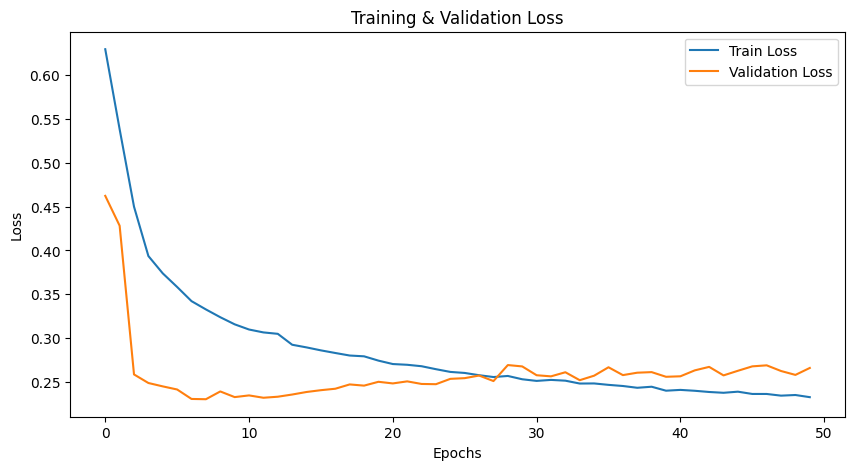

In [72]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

In [73]:
y_pred = model.predict(X_test)

def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true.flatten(), y_pred.flatten())
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true.flatten(), y_pred.flatten())
    return {"MSE": mse, "RMSE": rmse, "MAE": mae}

metrics = evaluate_model(y_test, y_pred)
print(metrics)

48/48 [==============================] - 1s 7ms/step
{'MSE': 0.6757415161595324, 'RMSE': 0.8220349847540143, 'MAE': 0.5577142575747653}


### Test model

In [74]:
model = tf.keras.models.load_model(best_model_path)
scaler = joblib.load(scaler_path)

In [75]:
last_input = X_test[-1] 
last_input = np.expand_dims(last_input, axis=0)

In [76]:
num_future_steps = 56  # next 7 days
predictions = []

for _ in range(num_future_steps // 8):  
    pred = model.predict(last_input) 
    predictions.append(pred)

    last_input = np.concatenate([last_input[:, 8:, :], pred], axis=1)

predictions = np.concatenate(predictions, axis=1) 

1/1 [==============================] - 0s 22ms/step


In [77]:
predictions_original = scaler.inverse_transform(predictions.reshape(-1, len(features))).reshape(56, len(features))

In [78]:
future_dates = pd.date_range(data.index[-1] + pd.Timedelta(hours=3), periods=56, freq="3h")

In [79]:
df_predictions = pd.DataFrame(predictions_original, columns=features)

df_predictions.index = future_dates

df_predictions.head()

,temp,dwpt,rhum,prcp,wdir,wspd,pres
2025-02-22 08:00:00,22.240620,20.693651,90.008911,0.193741,242.796112,23.597910,1015.810425
2025-02-22 11:00:00,24.000172,20.815216,82.512230,0.240643,161.933502,26.567228,1016.798584
2025-02-22 14:00:00,25.562756,20.860069,75.621796,0.246274,75.543381,29.983385,1016.173157
2025-02-22 17:00:00,25.235411,20.863096,76.451401,0.280662,49.286972,30.944279,1014.540405
2025-02-22 20:00:00,23.868773,20.940605,82.821228,0.181482,98.093468,28.132191,1014.721680


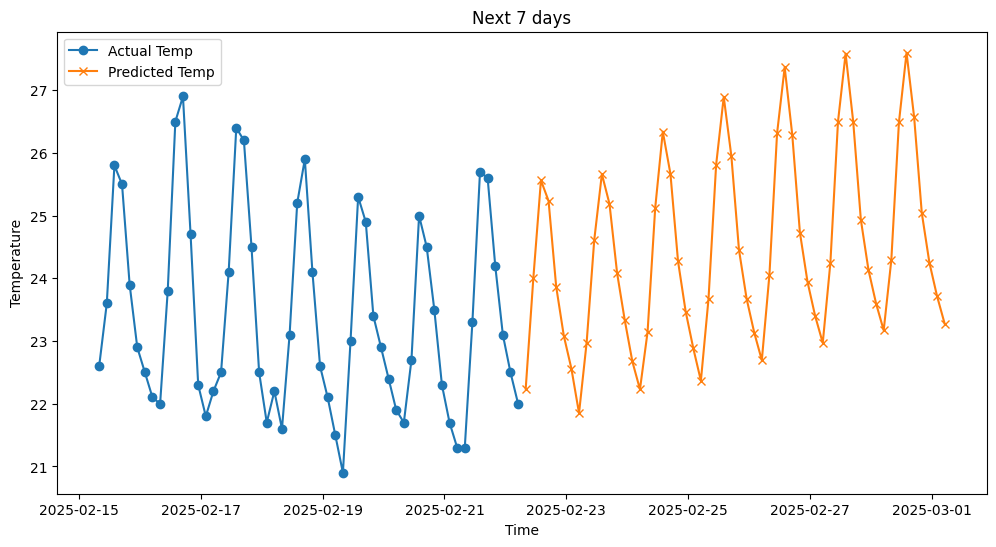

In [80]:
plt.figure(figsize=(12, 6))

plt.plot(data.index[-56:], scaler.inverse_transform(X_test[-1].reshape(-1, len(features)))[:, 0], label="Actual Temp", marker="o")

plt.plot(future_dates, predictions_original[:, 0], label="Predicted Temp", marker="x")

plt.xlabel("Time")
plt.ylabel("Temperature")
plt.title("Next 7 days")
plt.legend()
plt.show()